/tmp/ipykernel_7103/1058594582.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_records_df['admittime'] = pd.to_datetime(complete_records_df['admittime'])
/tmp/ipykernel_7103/1058594582.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_records_df['dischtime'] = pd.to_datetime(complete_records_df['dischtime'])
/tmp/ipykernel_7103/1058594582.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

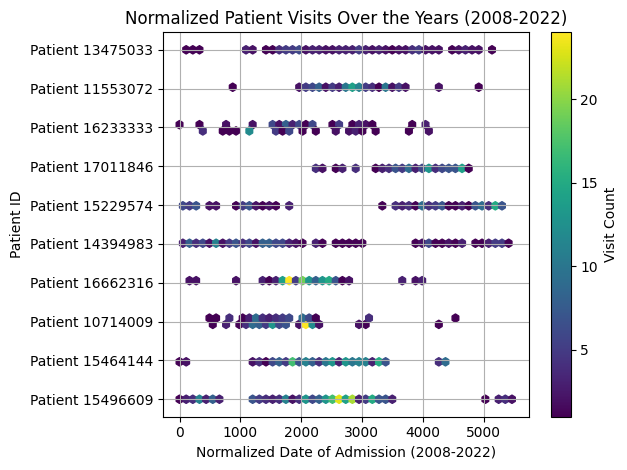

In [ ]:
#%pip install missingno
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from datetime import timedelta


#reference
df_icd_ref = pd.read_csv('/home/bhux/mikayla/ProjectLLM-hlth/Superutil/hosp/d_icd_diagnoses.csv.gz', compression='gzip')
df_proc_ref = pd.read_csv('/home/bhux/mikayla/ProjectLLM-hlth/Superutil/hosp/d_icd_procedures.csv.gz', compression='gzip')
#data
df_demo = pd.read_csv('/home/bhux/mikayla/ProjectLLM-hlth/Superutil/hosp/admissions.csv.gz', compression='gzip')
df_diag = pd.read_csv('/home/bhux/mikayla/ProjectLLM-hlth/Superutil/hosp/diagnoses_icd.csv.gz', compression='gzip')
df_ptnt = pd.read_csv('/home/bhux/mikayla/ProjectLLM-hlth/Superutil/hosp/patients.csv.gz', compression='gzip')

#----------------------------------visualize data-----------------------------------------------------
#----icd codes data----
icd_code_diag_ref = df_icd_ref['icd_code']
long_title_diag_ref = df_icd_ref['long_title']
icd_version_diag_ref = df_icd_ref['icd_version']

icd_code_proc_ref = df_proc_ref['icd_code']
long_title_proc_ref = df_proc_ref['long_title']
icd_version_proc_ref = df_proc_ref['icd_version']

#---demographic data---
#patient identifiers
hadm_id = df_demo['hadm_id']
subject_id = df_demo['subject_id']

#time spent, death time
admittime = df_demo['admittime']
dischtime = df_demo['dischtime']
edregtime = df_demo['edregtime']
edouttime = df_demo['edouttime']
deathtime = df_demo['deathtime']

#clinical info
hospital_expire_flag = df_demo['hospital_expire_flag']
admission_type = df_demo['admission_type']
admission_location = df_demo['admission_location']
discharge_location = df_demo['discharge_location']

#demographics
insurance = df_demo['insurance']
language = df_demo['language']
marital_status = df_demo['marital_status']
race = df_demo['race']

#---diagnosis data---
hadm_id = df_diag['hadm_id']
subject_id = df_diag['subject_id']
seq_num = df_diag['seq_num']
icd_code = df_diag['icd_code']
icd_version = df_diag['icd_version']

#---patient data---
subject_id = df_ptnt['subject_id']
gender = df_ptnt['gender']
anchor_age = df_ptnt['anchor_age']
anchor_year = df_ptnt['anchor_year']
anchor_year_group = df_ptnt['anchor_year_group']
#----------------------------------------------------------------------------------------------------------------

# Merge demographic and patient data
df = pd.merge(df_demo, df_ptnt[['subject_id', 'gender', 'anchor_age']], on='subject_id', how='left')

# Group ICD diagnostic data
df_diag_grouped = df_diag.groupby('hadm_id').agg({
    'icd_code': list,
    'seq_num': list,
    'icd_version': list
}).reset_index()

# Merge grouped ICD data
df = pd.merge(df, df_diag_grouped, on='hadm_id', how='left')

# Fill missing insurance values
df['insurance'] = df['insurance'].fillna('None')

#filter for complete data in critical columns
critical_columns = [
    'subject_id', 'hadm_id', 'admittime', 'dischtime',
    'admission_type', 'insurance', 'language', 
    'marital_status', 'race', 'edregtime', 'edouttime']
complete_records_df = df.dropna(subset=critical_columns)

#display(complete_records_df)
#print(complete_records_df.columns)

# sampled_subject_ids = pd.Series(complete_records_df['subject_id'].unique()).sample(n=10000, random_state=42)
# sampled_data = complete_records_df[complete_records_df['subject_id'].isin(sampled_subject_ids)]

#sampled_data.to_csv('sampled_data_complete_records.csv', index=False)
#print(f"Sampled data with complete records exported to 'sampled_data_complete_records.csv' with {len(sampled_data)} rows and {len(sampled_data.columns)} columns.")

# Ensure time columns are in datetime format
complete_records_df['admittime'] = pd.to_datetime(complete_records_df['admittime'])
complete_records_df['dischtime'] = pd.to_datetime(complete_records_df['dischtime'])

complete_records_df['admit_year'] = complete_records_df['admittime'].dt.year
complete_records_df['discharge_year'] = complete_records_df['dischtime'].dt.year
study_periods = complete_records_df.groupby('subject_id').agg(
    min_year=('admit_year', 'min'),
    max_year=('discharge_year', 'max')
).reset_index()
study_periods['years_in_study'] = study_periods['max_year'] - study_periods['min_year'] + 1

# Calculate ER time for each visit in hours
complete_records_df['er_time_hours'] = (complete_records_df['dischtime'] - complete_records_df['admittime']).dt.total_seconds() / 3600

# ICD Code Aggregation
icd_summary = df_diag.groupby('subject_id').agg(
    accumulated_icd_codes=('icd_code', lambda x: x.dropna().tolist() if len(x.dropna()) > 0 else ['NONE']),
    accumulated_icd_versions=('icd_version', lambda x: x.dropna().tolist() if len(x.dropna()) > 0 else ['NONE']),
    unique_icd_codes=('icd_code', lambda x: list(set(x.dropna())) if len(x.dropna()) > 0 else ['NONE']),
    icd_code_count=('icd_code', 'count'),
    unique_icd_code_count=('icd_code', lambda x: len(set(x.dropna())) if len(x.dropna()) > 0 else 0)

).reset_index()

admission_summary = complete_records_df.groupby('subject_id').agg(
    admission_types=('admission_type', lambda x: x.dropna().tolist() if len(x.dropna()) > 0 else ['NONE']),
    admission_locations=('admission_location', lambda x: x.dropna().tolist() if len(x.dropna()) > 0 else ['NONE']),
    discharge_locations=('discharge_location', lambda x: x.dropna().tolist() if len(x.dropna()) > 0 else ['NONE'])
).reset_index()

# Summarize for each patient (subject_id)
patient_summary = complete_records_df.groupby('subject_id').agg(
    total_visits=('hadm_id', 'nunique'),
    total_er_time_hours=('er_time_hours', 'sum'),
    avg_er_time_hours=('er_time_hours', 'mean'),
    insurance=('insurance', 'first'),
    language=('language', 'first'),
    marital_status=('marital_status', 'first'),
    race=('race', 'first'),
    age=('anchor_age', 'max'),
    sex=('gender', 'first'),
    hospital_expire_flag=('hospital_expire_flag', 'max'),
).reset_index()

patient_summary = patient_summary.merge(icd_summary, on='subject_id', how='left')
patient_summary = pd.merge(patient_summary, admission_summary, on='subject_id', how='left')
patient_summary = pd.merge(patient_summary, study_periods[['subject_id', 'years_in_study']], on='subject_id', how='left')

patient_summary['avg_visits_per_year'] = patient_summary['total_visits'] / patient_summary['years_in_study']

# Sort by total ER time in descending order
patient_summary_sorted = patient_summary.sort_values(by='total_visits', ascending=False).reset_index(drop=True)
#patient_summary_sorted.to_csv('patient_er_summary_with_demographics.csv', index=False)
#print(patient_summary_sorted.head(15))  # Show the top 10 as an example

percentile_75 = patient_summary_sorted['total_er_time_hours'].quantile(0.75)
top_25_percent = patient_summary_sorted[patient_summary_sorted['total_er_time_hours'] > percentile_75]

#-----------------------------------------------------------
#investigating 
# # num_top_25_percent = top_25_percent.shape[0]
# print(f"Number of subjects in the top 25% for total ER time: {num_top_25_percent}")

# last_top_25_member = patient_summary_sorted[patient_summary_sorted['total_er_time_hours'] == percentile_75]
# print("Last member of the top 25%:")
#display(last_top_25_member)

# unknown_race_count = complete_records_df[complete_records_df['race'] == 'UNKNOWN'].shape[0]
# print(f"Number of records with 'Unknown' race: {unknown_race_count}")
#-------------------------------------------------------------


# Get the top 10 patients with the most total visits
top_10_patients = patient_summary_sorted.nlargest(10, 'total_visits')['subject_id']

# Load the complete records dataset
complete_records_df['admittime'] = pd.to_datetime(complete_records_df['admittime'])

# Filter the complete records for these top 10 patients
top_10_data = complete_records_df[complete_records_df['subject_id'].isin(top_10_patients)]

min_date = pd.to_datetime("2008-01-01")
max_date = pd.to_datetime("2022-12-31")
time_range = (max_date - min_date).days

# Create a mapping for patient IDs to integer indices for plotting
patient_id_mapping = {pid: idx for idx, pid in enumerate(top_10_patients)}

# Apply normalization to the dates
#top_10_data['admittime'] = min_date + (top_10_data['admittime'] - top_10_data['admittime'].min()) % timedelta(days=time_range)
top_10_data['admittime_normalized'] = min_date + (top_10_data['admittime'] - top_10_data['admittime'].min()) % timedelta(days=time_range)
top_10_data['admittime_days'] = (top_10_data['admittime_normalized'] - min_date).dt.days
top_10_data['patient_index'] = top_10_data['subject_id'].map(patient_id_mapping)


plt.hexbin(top_10_data['admittime_days'], 
           top_10_data['patient_index'], 
           gridsize=50, cmap='viridis', mincnt=1)

# Plotting
# plt.figure(figsize=(14, 6))
# for subject_id, group in top_10_data.groupby('subject_id'):
#     jitter = np.random.uniform(-0.2, 0.2, len(group))  # Small random offset
#     plt.scatter(group['admittime'], [patient_id_mapping[subject_id] + j for j in jitter], 
#                 alpha=0.7, label=f"Patient {subject_id}")
    # plt.scatter(group['admittime'], [patient_id_mapping[subject_id]] * len(group), label=f"Patient {subject_id}", alpha=0.7)

plt.colorbar(label='Visit Count')
plt.xlabel("Normalized Date of Admission (2008-2022)")
plt.ylabel("Patient ID")
plt.title("Normalized Patient Visits Over the Years (2008-2022)")
#plt.xticks(rotation=45)
plt.yticks(range(10), [f"Patient {pid}" for pid in top_10_patients])
plt.grid(True)
plt.tight_layout()
plt.show()


# plt.xlabel("Normalized Date of Admission (2008-2022)")
# plt.ylabel("Patient Index (Top 10)")
# plt.title("Scatter Plot of Admission Dates for Top 10 Patients (Normalized 2008-2022)")
# plt.yticks(range(10), [f"Patient {pid}" for pid in top_10_patients])
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.tight_layout()
# plt.show()


        subject_id   hadm_id            admittime            dischtime  \
0         10000032  22595853  2180-05-06 22:23:00  2180-05-07 17:15:00   
1         10000032  22841357  2180-06-26 18:27:00  2180-06-27 18:49:00   
2         10000032  25742920  2180-08-05 23:44:00  2180-08-07 17:50:00   
3         10000032  29079034  2180-07-23 12:35:00  2180-07-25 17:55:00   
4         10000068  25022803  2160-03-03 23:16:00  2160-03-04 06:26:00   
...            ...       ...                  ...                  ...   
546023    19999828  25744818  2149-01-08 16:44:00  2149-01-18 17:00:00   
546024    19999828  29734428  2147-07-18 16:23:00  2147-08-04 18:10:00   
546025    19999840  21033226  2164-09-10 13:47:00  2164-09-17 13:42:00   
546026    19999840  26071774  2164-07-25 00:27:00  2164-07-28 12:15:00   
546027    19999987  23865745  2145-11-02 21:38:00  2145-11-11 12:57:00   

                  deathtime  admission_type admit_provider_id  \
0                       NaN          URGENT   

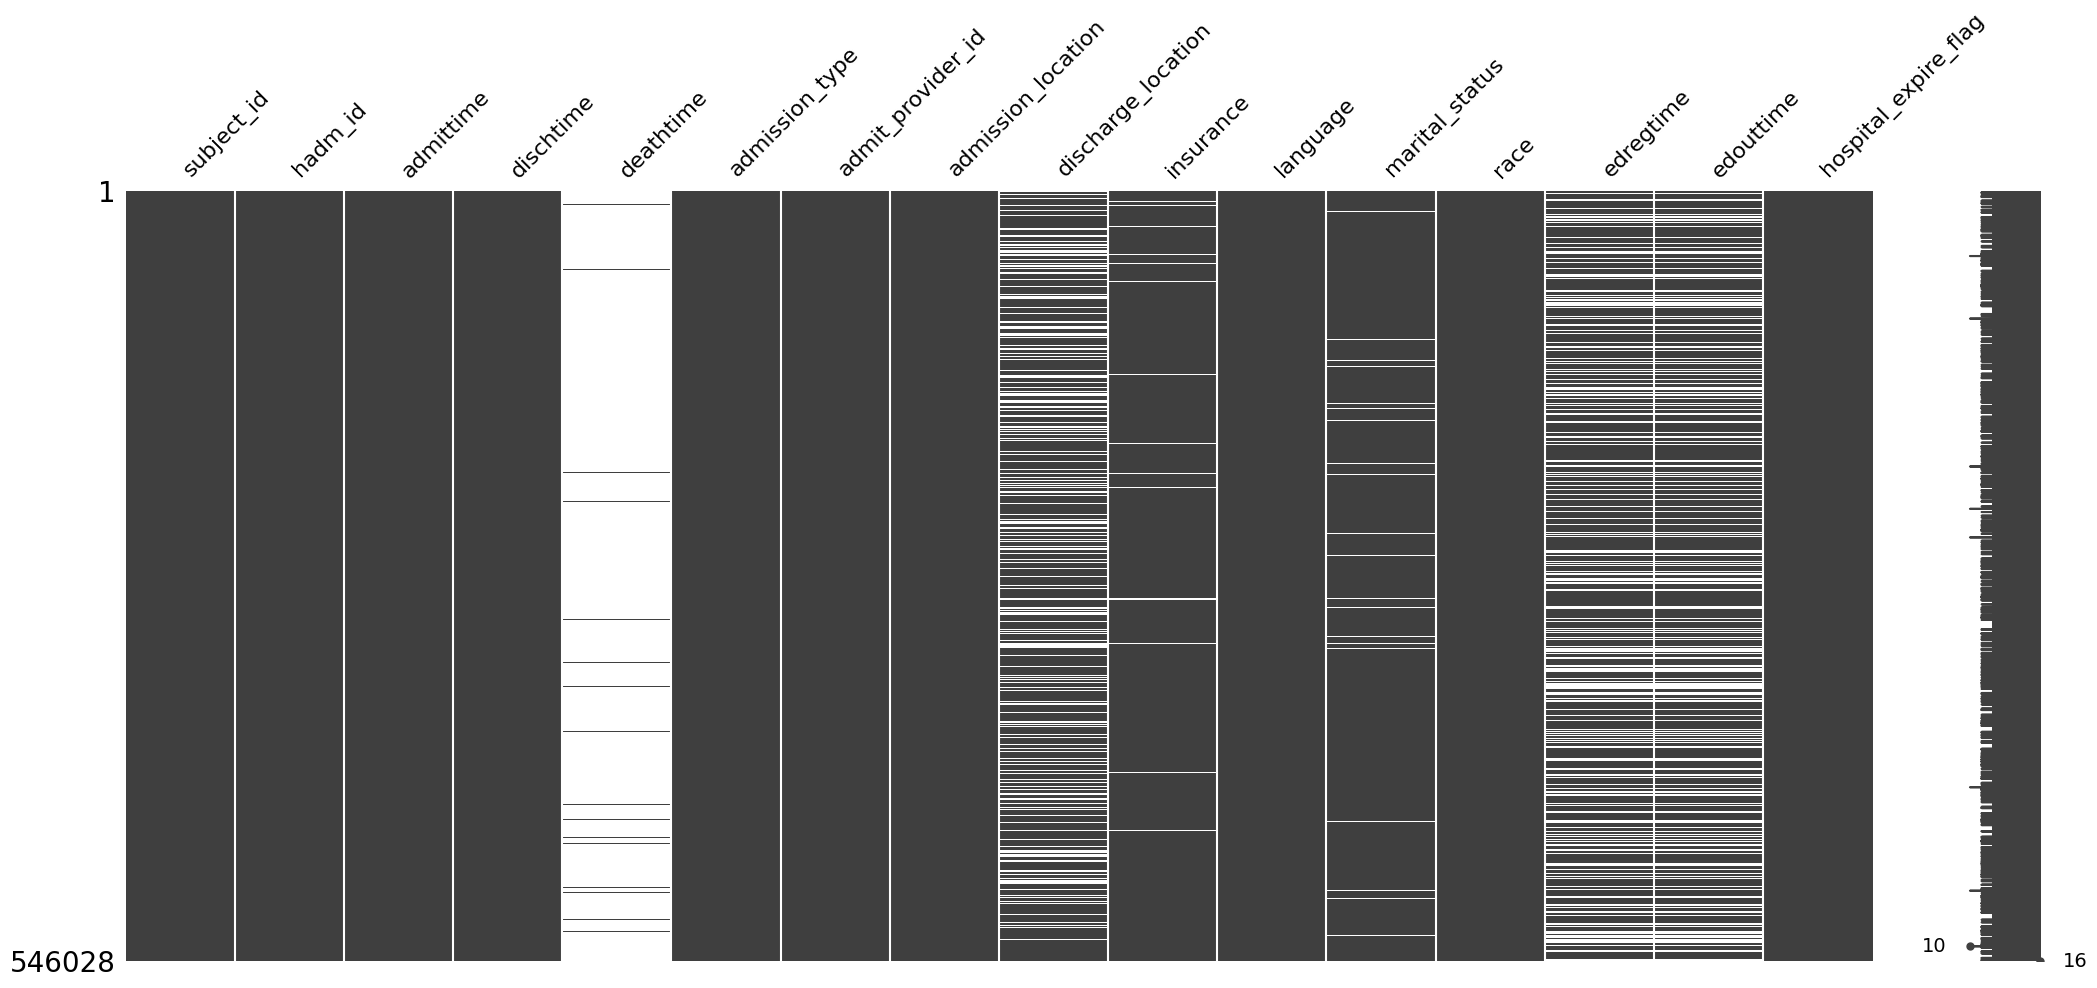

In [ ]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

df = pd.read_csv('/home/bhux/mikayla/ProjectLLM-hlth/Superutil/hosp/admissions.csv.gz', compression='gzip')

#print(df)
# print("dataframe info: " , df.info())
# print("nulls:", df.isnull().sum())
# print("dataframe shape:" ,df.shape)  # (rows, columns)
# msno.matrix(df)  # Shows a heatmap of missing values
# plt.show()

Clustering Progress: 100%|██████████| 4/4 [18:42<00:00, 280.66s/k]


Execution time: 1125.00 seconds


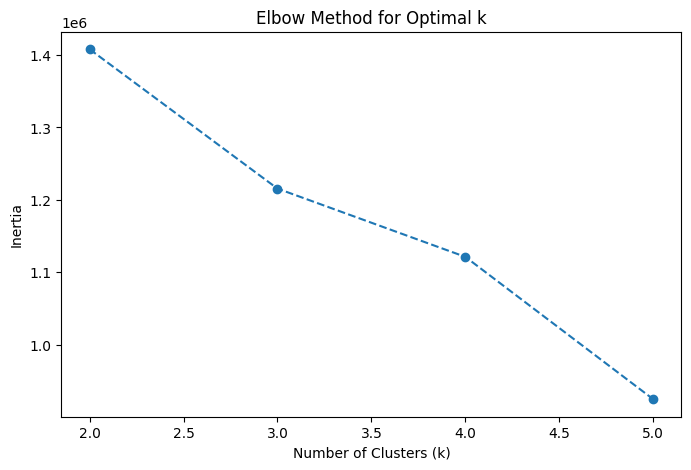

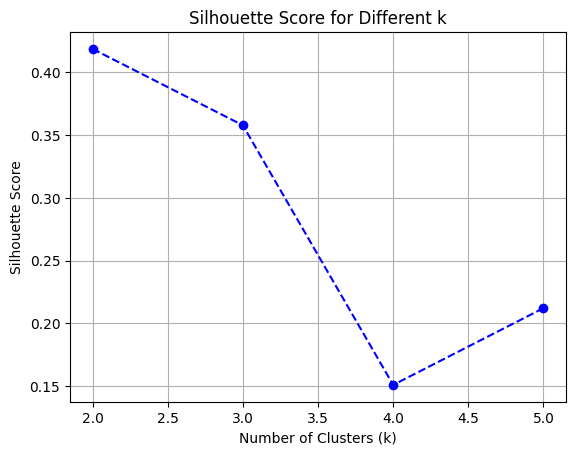

In [ ]:
#code takes way toooo long

%pip install faiss-cpu

import pandas as pd
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModel

from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

start_time = time.time()

complete_records_df  = pd.read_csv('/home/bhux/mikayla/ProjectLLM-hlth/Superutil/hosp/patient_er_summary_with_demographics.csv')

tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")
model = AutoModel.from_pretrained("medicalai/ClinicalBERT")


patient_summary_sorted = pd.read_csv('patient_er_summary_with_demographics.csv').head(5)
#print(patient_summary_sorted.head())

# numerical_features = ['total_visits', 'total_er_time_hours', 'avg_er_time_hours', 'age']
# categorical_features = ['insurance', 'language', 'marital_status', 'race', 'sex']

# # One-hot encode categorical variables
# encoder = OneHotEncoder(drop='first')
# encoded_cats = encoder.fit_transform(complete_records_df[categorical_features]).toarray()

# # Normalize numerical features
# scaler = StandardScaler()
# scaled_numericals = scaler.fit_transform(complete_records_df[numerical_features])

# # Combine processed features
# import numpy as np
# X = np.hstack((scaled_numericals, encoded_cats))

# # Apply K-Means
# kmeans = KMeans(n_clusters=4, random_state=42)
# complete_records_df['cluster'] = kmeans.fit_predict(X)

# print(complete_records_df[['subject_id', 'cluster']].head())

features = ['total_visits', 'total_er_time_hours', 'avg_er_time_hours', 'age']

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(patient_summary_sorted[features])

# Select numerical columns only (excluding categorical/text data)
numeric_cols = complete_records_df.select_dtypes(include=['number']).columns
numeric_data = complete_records_df[numeric_cols]  # Extract numerical data

# Handle NaN values (impute missing values with mean)
imputer = SimpleImputer(strategy="mean")  # You can also use "median" or "most_frequent"
imputed_data = imputer.fit_transform(numeric_data)

# Standardize the data
scaled_data = StandardScaler().fit_transform(imputed_data)

K_range = range(2, 6)  # Reduced range for faster computation

inertia = []
silhouette_scores = []

# Reduce dimensions for faster clustering (Optional)
pca = PCA(n_components=10)  # Keep only top 5 principal components
X_reduced = pca.fit_transform(scaled_data)

# Use tqdm for progress tracking
for k in tqdm(K_range, desc="Clustering Progress", unit="k"):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, n_init=5, batch_size=512)  # Larger batch size
    cluster_labels = kmeans.fit_predict(X_reduced)

    inertia.append(kmeans.inertia_)
    if k > 1:
        from sklearn.metrics import silhouette_score
        silhouette_scores.append(silhouette_score(X_reduced, cluster_labels))

# End timer
end_time = time.time()
execution_time = end_time - start_time
print(f"\nExecution time: {execution_time:.2f} seconds")

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Plot Silhouette Score
plt.plot(K_range, silhouette_scores, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k')
plt.grid(True)
plt.show()



In [12]:
import numpy as np

df  = pd.read_csv('/home/bhux/mikayla/ProjectLLM-hlth/Superutil/hosp/patient_er_summary_with_demographics.csv')


import pandas as pd
import numpy as np

# Bin patients by visit count
def categorize_visits(n):
    if n == 1:
        return '1'
    elif 2 <= n <= 3:
        return '2-3'
    elif 4 <= n <= 6:
        return '4-6'
    elif 7 <= n <= 10:
        return '7-10'
    else:
        return '11+'

patient_summary['visit_bin'] = patient_summary['total_visits'].apply(categorize_visits)

# Calculate original distribution
original_distribution = (
    patient_summary['visit_bin']
    .value_counts(normalize=True)
    .rename('original_proportion')
    .sort_index()
)

# Stratified sampling
sampled_patients = (
    patient_summary
    .groupby('visit_bin', group_keys=False)
    .apply(lambda x: x.sample(frac=0.1, random_state=42))  # Adjust frac as needed
)

# Merge with complete_records_df
sampled_data = complete_records_df[complete_records_df['subject_id'].isin(sampled_patients['subject_id'])]

# Calculate sampled distribution
sampled_distribution = (
    sampled_patients['visit_bin']
    .value_counts(normalize=True)
    .rename('sampled_proportion')
    .sort_index()
)

# Combine into one display
distribution_comparison = pd.concat([original_distribution, sampled_distribution], axis=1)
print(distribution_comparison)

# Save the sampled data
sampled_data.to_csv('representative_sampled_data.csv', index=False)
print(f"Sample written to 'representative_sampled_data.csv' with {len(sampled_data)} rows.")



/tmp/ipykernel_7103/330297151.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=0.1, random_state=42))  # Adjust frac as needed


           original_proportion  sampled_proportion
visit_bin                                         
1                     0.649606            0.649632
11+                   0.019824            0.019814
2-3                   0.230237            0.230229
4-6                   0.073154            0.073146
7-10                  0.027179            0.027180
Sample written to 'representative_sampled_data.csv' with 17513 rows.


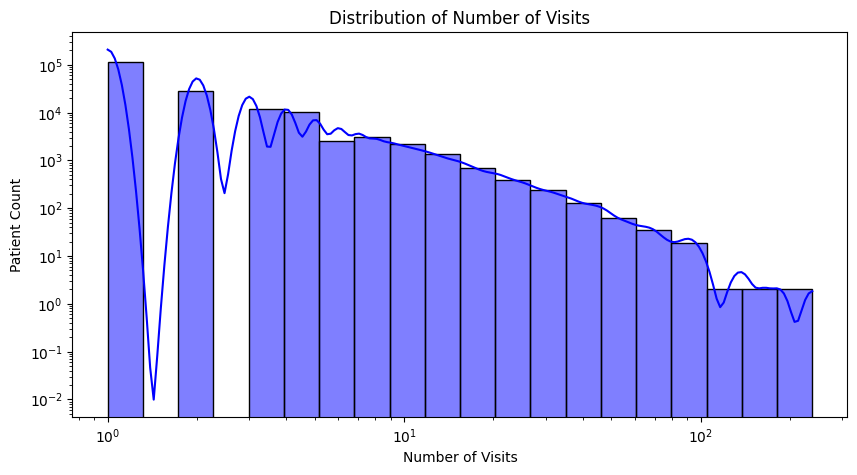

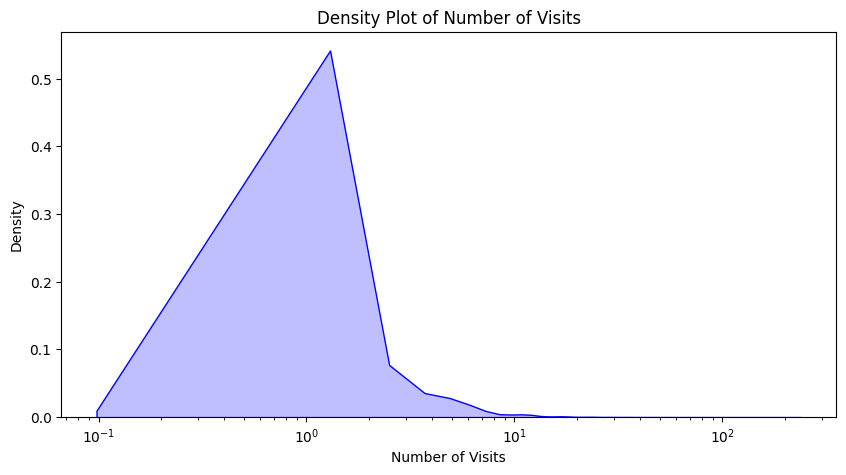

In [ ]:
#full distribution
df  = pd.read_csv('/home/bhux/mikayla/ProjectLLM-hlth/Superutil/hosp/patient_er_summary_with_demographics.csv')

import matplotlib.pyplot as plt
import seaborn as sns

#print(df.columns)

plt.figure(figsize=(10, 5))
plt.yscale("log")  # Apply logarithmic scale to the y-axis
plt.xscale("log")
sns.histplot(df["total_visits"], bins=20, kde=True, color="blue")  # Histogram with kernel density estimate
plt.xlabel("Number of Visits")
plt.ylabel("Patient Count")
plt.title("Distribution of Number of Visits")

plt.figure(figsize=(10, 5))

sns.kdeplot(df["total_visits"], color="blue", fill=True)  # Density plot (KDE)
plt.xscale("log")  # Logarithmic scale for better visualization (optional)
plt.xlabel("Number of Visits")
plt.ylabel("Density")
plt.title("Density Plot of Number of Visits")


plt.show()


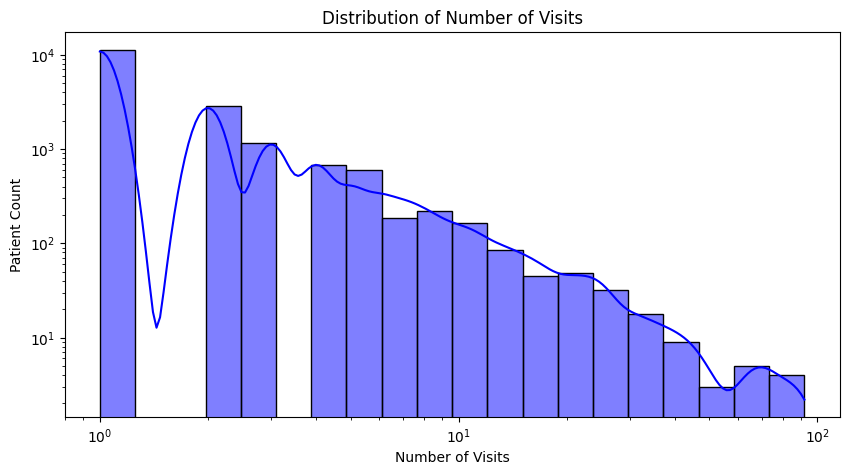

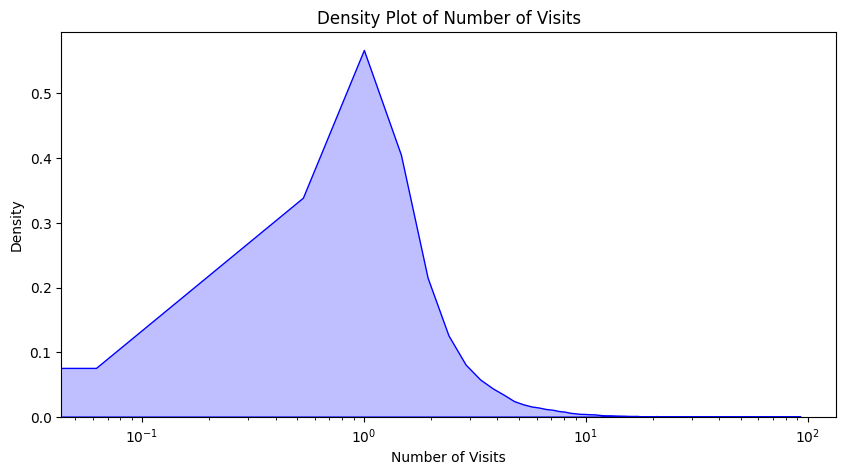

In [ ]:
#sampled distribution
df  = pd.read_csv('/home/bhux/mikayla/ProjectLLM-hlth/Superutil/hosp/representative_sampled_data.csv')

import matplotlib.pyplot as plt
import seaborn as sns

#print(df.columns)

plt.figure(figsize=(10, 5))
plt.yscale("log")  # Apply logarithmic scale to the y-axis
plt.xscale("log")
sns.histplot(df["total_visits"], bins=20, kde=True, color="blue")  # Histogram with kernel density estimate
plt.xlabel("Number of Visits")
plt.ylabel("Patient Count")
plt.title("Distribution of Number of Visits")

plt.figure(figsize=(10, 5))

sns.kdeplot(df["total_visits"], color="blue", fill=True)  # Density plot (KDE)
plt.xscale("log")  # Logarithmic scale for better visualization (optional)
plt.xlabel("Number of Visits")
plt.ylabel("Density")
plt.title("Density Plot of Number of Visits")


plt.show()

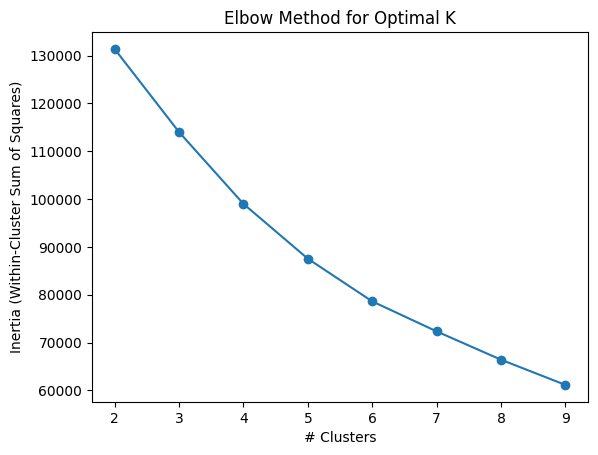

Optimal K based on the Elbow Method: 3
Best K based on Silhouette Score: 2
Final Chosen K: 2
Silhouette Score for K=2: 0.56


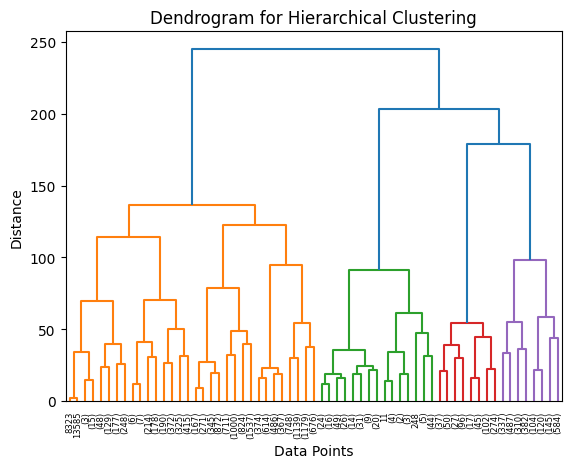

/home/bhux/mikayla/.conda/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/bhux/mikayla/.conda/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


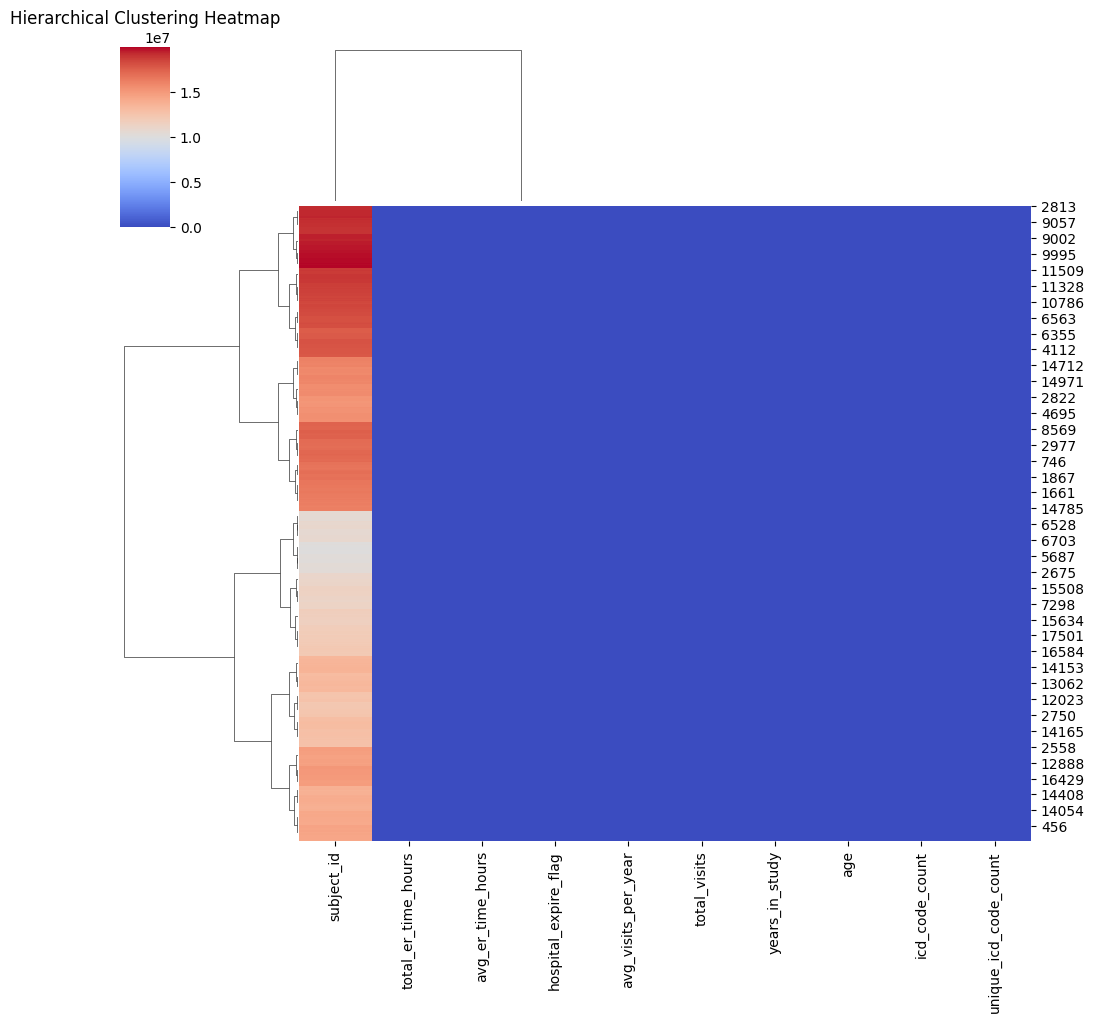

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

#full dataset
#df  = pd.read_csv('/home/bhux/mikayla/ProjectLLM-hlth/Superutil/hosp/patient_er_summary_with_demographics.csv')
#sampled dataset
df  = pd.read_csv('/home/bhux/mikayla/ProjectLLM-hlth/Superutil/hosp/representative_sampled_data.csv')


df.dropna(inplace=True)  # drop missing values
num_cols = df.select_dtypes(include=['float64', 'int64']).columns  # select num cols
df_scaled = StandardScaler().fit_transform(df[num_cols])  # standardize data

inertia = []
K_range = range(2, 10)  # checking clusters from 2 to 9, 1 useless 10 too high

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.xlabel("# Clusters")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal K")
plt.show()

#--what is the best k--------------------------------------------------
def find_best_k(inertia_values, K_range):
    diffs = np.diff(inertia_values)  # First derivative
    best_k = K_range[np.argmin(diffs) + 1]  # Find where drop is steepest
    return best_k

optimal_k = find_best_k(inertia, list(K_range))
print(f"Optimal K based on the Elbow Method: {optimal_k}")

silhouette_scores = {}
for k in [2, 5]:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled)
    silhouette_scores[k] = silhouette_score(df_scaled, labels)

# Choose the best K based on silhouette score
best_k_silhouette = max(silhouette_scores, key=silhouette_scores.get)
print(f"Best K based on Silhouette Score: {best_k_silhouette}")

# Final chosen K
final_k = min(optimal_k, best_k_silhouette)  # Pick the safest lower option
print(f"Final Chosen K: {final_k}")

# Fit K-Means with the chosen K
# kmeans = KMeans(n_clusters=final_k, random_state=42, n_init=10)
# df["Cluster"] = kmeans.fit_predict(df_scaled)
#------------------------------------------------------------------------

#K-Means Clustering
optimal_k = 2  # choose based on "best k calculated"
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_scaled)

df["Cluster"] = clusters  # add cluster label

#Silhouette Score for Evaluation
silhouette_avg = silhouette_score(df_scaled, clusters)
print(f"Silhouette Score for K={optimal_k}: {silhouette_avg:.2f}")

#Dendrogram for hierarchical clustering
Z = linkage(df_scaled, method='ward')
dendrogram(Z, truncate_mode="level", p=5)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

#Attach Dendrogram to a Heatmap
sns.clustermap(df[num_cols], cmap="coolwarm", method="ward")
plt.title("Hierarchical Clustering Heatmap")
plt.show()
